In [6]:
!pip install numpy==1.23.5
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 29.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
xarray 2025.1.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
bigframes 1.42.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 wh

ERROR: Operation cancelled by user
^C


In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose, STL, MSTL
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')
import os
from prophet import Prophet

# Download dataset

In [2]:
import kagglehub

path = kagglehub.dataset_download("jeanmidev/smart-meters-in-london")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/smart-meters-in-london


# Read Datasets

## Read hh_block_0

In [3]:
hh_block_0 = pd.read_csv('/kaggle/input/smart-meters-in-london/hhblock_dataset/hhblock_dataset/block_0.csv', parse_dates=['day'])

## Read hourly weather dataset

In [4]:
weather = pd.read_csv('/kaggle/input/smart-meters-in-london/weather_hourly_darksky.csv', parse_dates=['time'], index_col='time')

## block_0 head

In [5]:
hh_block_0.head()

,LCLid,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
0,MAC000002,2012-10-13,0.263,0.269,0.275,0.256,0.211,0.136,0.161,0.119,...,0.918,0.278,0.267,0.239,0.230,0.233,0.235,0.188,0.259,0.250
1,MAC000002,2012-10-14,0.262,0.166,0.226,0.088,0.126,0.082,0.123,0.083,...,1.075,0.956,0.821,0.745,0.712,0.511,0.231,0.210,0.278,0.159
2,MAC000002,2012-10-15,0.192,0.097,0.141,0.083,0.132,0.070,0.130,0.074,...,1.164,0.249,0.225,0.258,0.260,0.334,0.299,0.236,0.241,0.237
3,MAC000002,2012-10-16,0.237,0.237,0.193,0.118,0.098,0.107,0.094,0.109,...,0.966,0.172,0.192,0.228,0.203,0.211,0.188,0.213,0.157,0.202
4,MAC000002,2012-10-17,0.157,0.211,0.155,0.169,0.101,0.117,0.084,0.118,...,0.223,0.075,0.230,0.208,0.265,0.377,0.327,0.277,0.288,0.256


## weather dataset head

In [6]:
weather.head()

,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
time,,,,,,,,,,,
2011-11-11 00:00:00,5.97,104,10.24,8.86,1016.76,10.24,2.77,rain,partly-cloudy-night,0.91,Partly Cloudy
2011-11-11 01:00:00,4.88,99,9.76,8.83,1016.63,8.24,2.95,rain,partly-cloudy-night,0.94,Partly Cloudy
2011-11-11 02:00:00,3.70,98,9.46,8.79,1016.36,7.76,3.17,rain,partly-cloudy-night,0.96,Partly Cloudy
2011-11-11 03:00:00,3.12,99,9.23,8.63,1016.28,7.44,3.25,rain,fog,0.96,Foggy
2011-11-11 04:00:00,1.85,111,9.26,9.21,1015.98,7.24,3.70,rain,fog,1.00,Foggy


# Data Preprocessing

## Filter rows for a specific ID

In [7]:
hh_block_0_filtered = hh_block_0[hh_block_0['LCLid'] == 'MAC000002'].copy()

In [8]:
hh_block_0_filtered.head()

,LCLid,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
0,MAC000002,2012-10-13,0.263,0.269,0.275,0.256,0.211,0.136,0.161,0.119,...,0.918,0.278,0.267,0.239,0.230,0.233,0.235,0.188,0.259,0.250
1,MAC000002,2012-10-14,0.262,0.166,0.226,0.088,0.126,0.082,0.123,0.083,...,1.075,0.956,0.821,0.745,0.712,0.511,0.231,0.210,0.278,0.159
2,MAC000002,2012-10-15,0.192,0.097,0.141,0.083,0.132,0.070,0.130,0.074,...,1.164,0.249,0.225,0.258,0.260,0.334,0.299,0.236,0.241,0.237
3,MAC000002,2012-10-16,0.237,0.237,0.193,0.118,0.098,0.107,0.094,0.109,...,0.966,0.172,0.192,0.228,0.203,0.211,0.188,0.213,0.157,0.202
4,MAC000002,2012-10-17,0.157,0.211,0.155,0.169,0.101,0.117,0.084,0.118,...,0.223,0.075,0.230,0.208,0.265,0.377,0.327,0.277,0.288,0.256


## Drop the 'LCLid' column

In [9]:
hh_block_0_filtered.drop(columns='LCLid', inplace=True)

In [10]:
hh_block_0_filtered.head()

,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,hh_8,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
0,2012-10-13,0.263,0.269,0.275,0.256,0.211,0.136,0.161,0.119,0.167,...,0.918,0.278,0.267,0.239,0.230,0.233,0.235,0.188,0.259,0.250
1,2012-10-14,0.262,0.166,0.226,0.088,0.126,0.082,0.123,0.083,0.120,...,1.075,0.956,0.821,0.745,0.712,0.511,0.231,0.210,0.278,0.159
2,2012-10-15,0.192,0.097,0.141,0.083,0.132,0.070,0.130,0.074,0.124,...,1.164,0.249,0.225,0.258,0.260,0.334,0.299,0.236,0.241,0.237
3,2012-10-16,0.237,0.237,0.193,0.118,0.098,0.107,0.094,0.109,0.091,...,0.966,0.172,0.192,0.228,0.203,0.211,0.188,0.213,0.157,0.202
4,2012-10-17,0.157,0.211,0.155,0.169,0.101,0.117,0.084,0.118,0.080,...,0.223,0.075,0.230,0.208,0.265,0.377,0.327,0.277,0.288,0.256


##Melt the hh_ columns into one column (long format)

In [11]:
hh_block_0_filtered = hh_block_0_filtered.melt(id_vars=['day'],
                       value_vars=[col for col in hh_block_0_filtered.columns if col.startswith('hh_')],
                       var_name='half_hour',
                       value_name='consumption')

In [12]:
hh_block_0_filtered.head()

,day,half_hour,consumption
0,2012-10-13,hh_0,0.263
1,2012-10-14,hh_0,0.262
2,2012-10-15,hh_0,0.192
3,2012-10-16,hh_0,0.237
4,2012-10-17,hh_0,0.157


## Sort by date and half-hour slot

In [13]:
hh_block_0_filtered['day'] = pd.to_datetime(hh_block_0_filtered['day'])
hh_block_0_filtered = hh_block_0_filtered.sort_values(['day', 'half_hour'])

In [14]:
hh_block_0_filtered.head()

,day,half_hour,consumption
0,2012-10-13,hh_0,0.263
498,2012-10-13,hh_1,0.269
4980,2012-10-13,hh_10,0.168
5478,2012-10-13,hh_11,0.107
5976,2012-10-13,hh_12,0.166


## Extract the half-hour index

In [15]:
hh_block_0_filtered['hh_index'] = hh_block_0_filtered['half_hour'].str.extract('hh_(\d+)').astype(int)

## Create datetime index: date + hh_index * 30 minutes

In [16]:
hh_block_0_filtered['datetime'] = hh_block_0_filtered['day'] + pd.to_timedelta(hh_block_0_filtered['hh_index'] * 30, unit='min')

##Set the datetime index and drop unnecessary columns

In [17]:
hh_block_0_filtered = hh_block_0_filtered.set_index('datetime')[['consumption']]

In [18]:
hh_block_0_filtered.head()

,consumption
datetime,
2012-10-13 00:00:00,0.263
2012-10-13 00:30:00,0.269
2012-10-13 05:00:00,0.168
2012-10-13 05:30:00,0.107
2012-10-13 06:00:00,0.166


In [19]:
hh_block_0_hourly = hh_block_0_filtered.resample("H").mean()

In [20]:
hh_block_0_hourly.head()

,consumption
datetime,
2012-10-13 00:00:00,0.2660
2012-10-13 01:00:00,0.2655
2012-10-13 02:00:00,0.1735
2012-10-13 03:00:00,0.1400
2012-10-13 04:00:00,0.1380


## Join with weather dataset

In [21]:
hh_block_0_hourly_weather = hh_block_0_hourly.join(weather['temperature']).dropna()

In [22]:
hh_block_0_hourly_weather.head()

,consumption,temperature
datetime,,
2012-10-13 00:00:00,0.2660,8.78
2012-10-13 01:00:00,0.2655,8.27
2012-10-13 02:00:00,0.1735,7.87
2012-10-13 03:00:00,0.1400,7.89
2012-10-13 04:00:00,0.1380,7.74


In [23]:
hh_block_0_hourly_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11950 entries, 2012-10-13 00:00:00 to 2014-02-27 23:00:00
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   consumption  11950 non-null  float64
 1   temperature  11950 non-null  float64
dtypes: float64(2)
memory usage: 280.1 KB


## Changing Frequencies

In [24]:
hourly_data = hh_block_0_hourly_weather.resample('H').mean().dropna()
daily_data = hh_block_0_hourly_weather.resample('D').mean().dropna()
weekly_data = hh_block_0_hourly_weather.resample('W').mean().dropna()
monthly_data = hh_block_0_hourly_weather.resample('M').mean().dropna()
annualy_data = hh_block_0_hourly_weather.resample('A').mean().dropna()

# Show some plots

##Original data

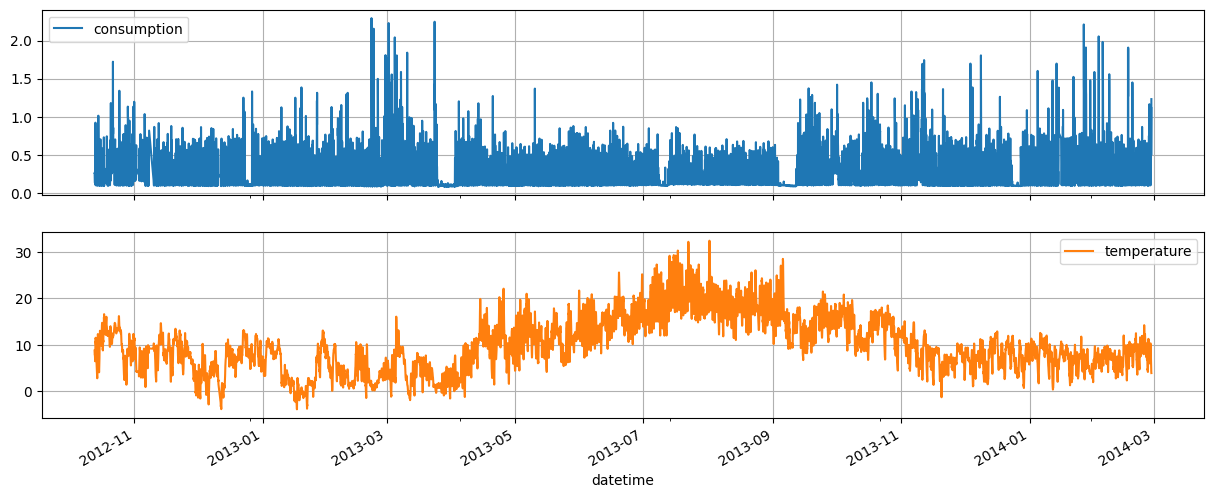

In [25]:
hh_block_0_hourly_weather.plot(subplots=True, figsize=(15, 6), grid=True)
plt.show()

## Plot differtent Frequencies

- as we can observe the consumption increase when the temprature decreases

### Hourly

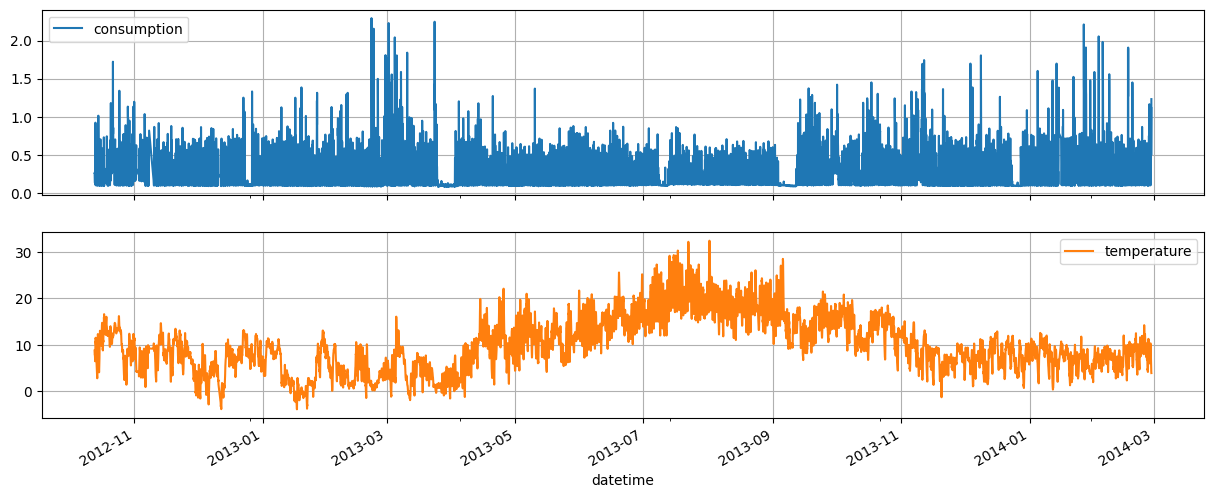

In [26]:
hourly_data.plot(subplots=True, figsize=(15, 6), grid=True)
plt.show()

### Daily

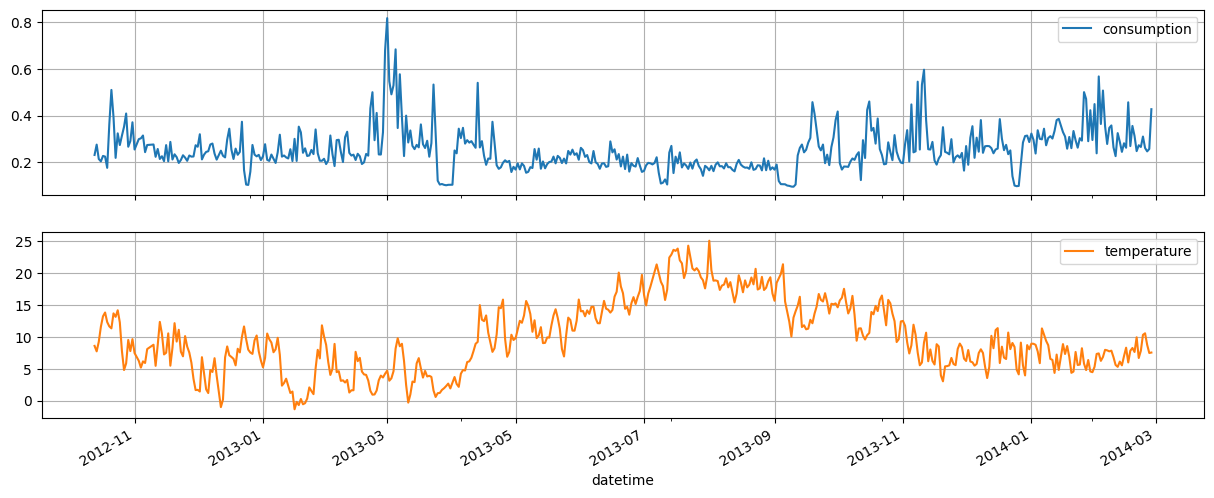

In [27]:
daily_data.plot(subplots=True, figsize=(15, 6), grid=True)
plt.show()

### Weekly

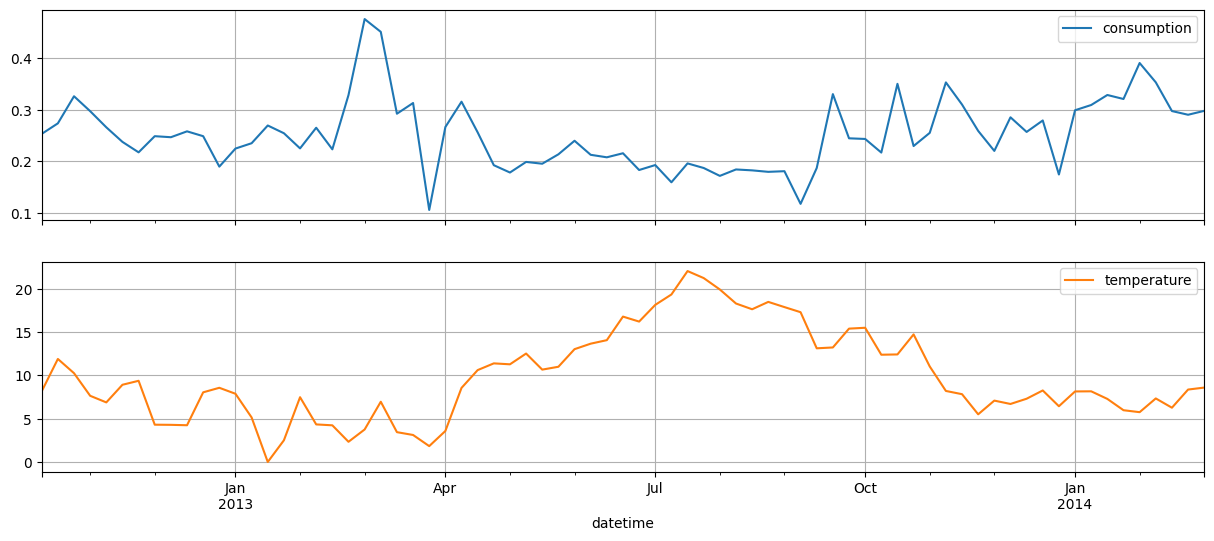

In [28]:
weekly_data.plot(subplots=True, figsize=(15, 6), grid=True)
plt.show()

### Monthly

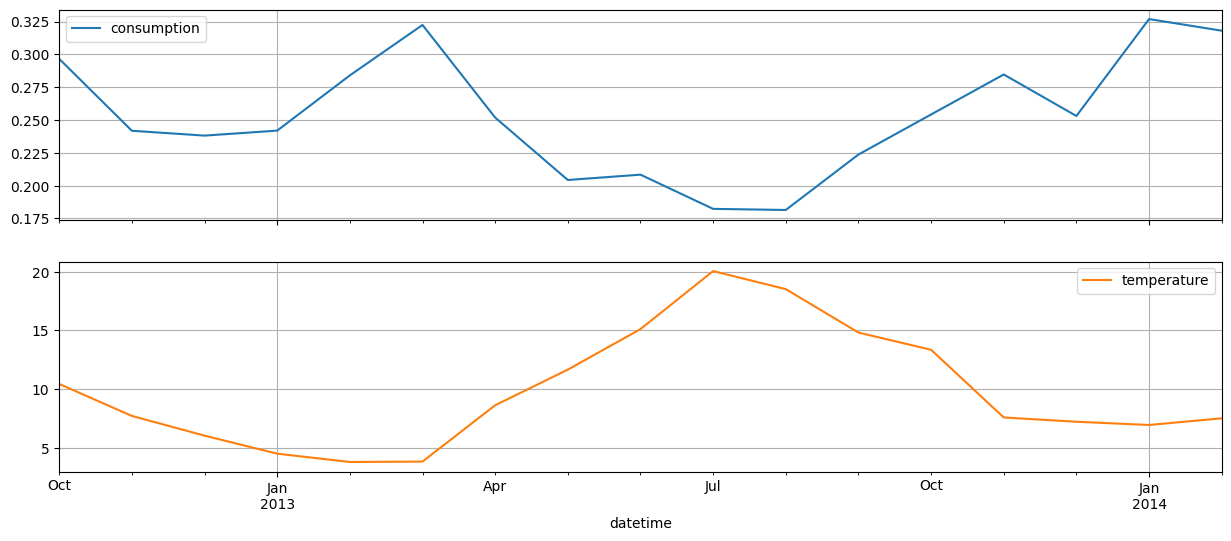

In [29]:
monthly_data.plot(subplots=True, figsize=(15, 6), grid=True)
plt.show()

## Heatmap to show correlation

- shows a negative correlation

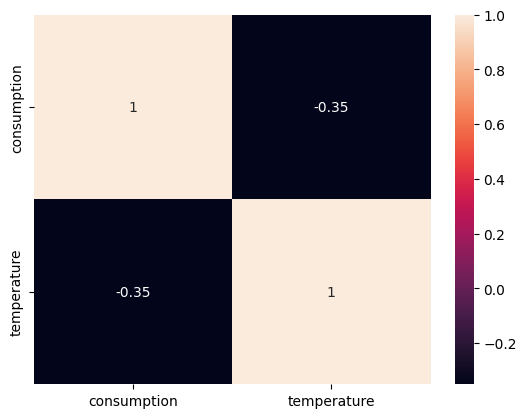

In [30]:
corr = daily_data.corr()
sns.heatmap(corr, annot=True)
plt.show()

#Decomposition

## Daily Energy Consumption with Moving Average

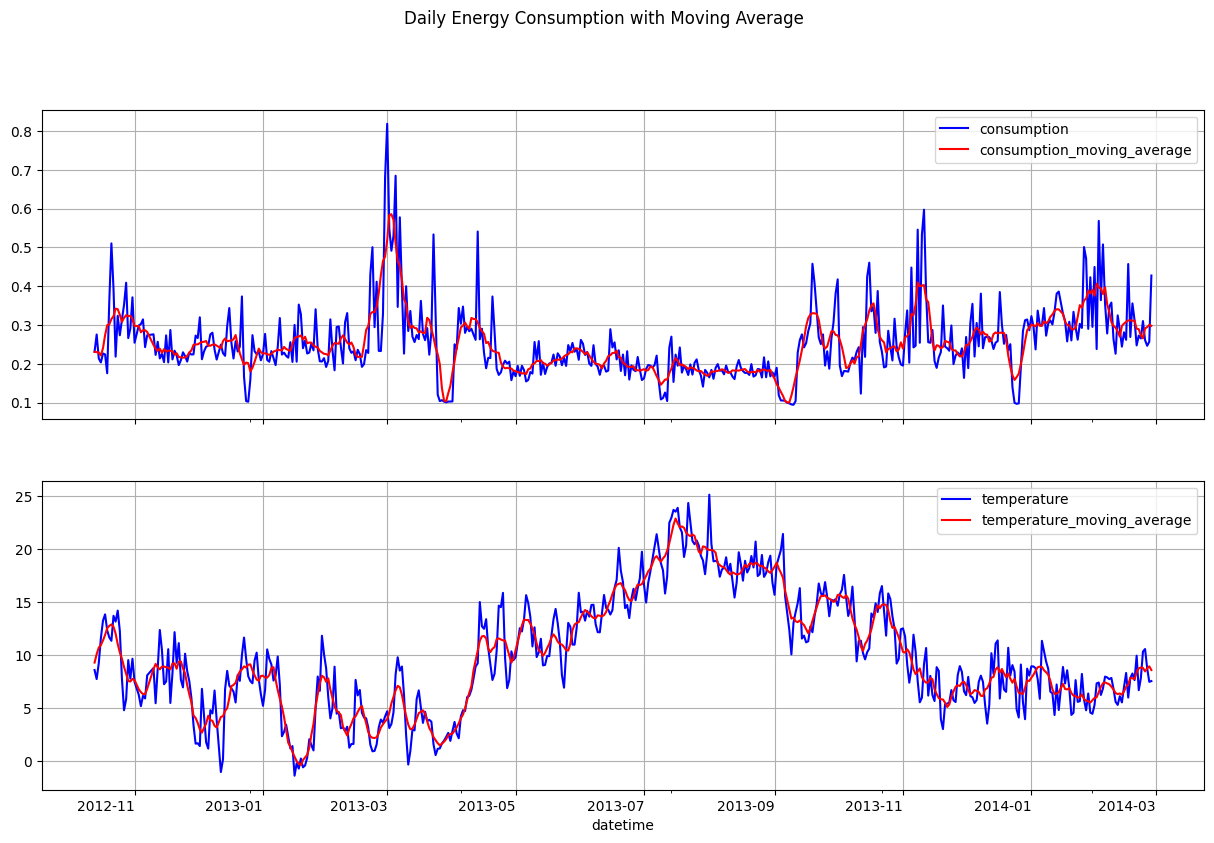

In [31]:
rolling_window = '7D'
trend_ma = daily_data.rolling(window=rolling_window, center=True).mean().add_suffix('_moving_average')
ax = daily_data.plot(subplots=True, title='Daily Energy Consumption with Moving Average', color='blue', figsize=(15, 10), grid=True)
trend_ma.plot(subplots=True, ax=ax, color='red', grid=True)
plt.show()

## Seasonality

- the data is not stationary

### Hourly

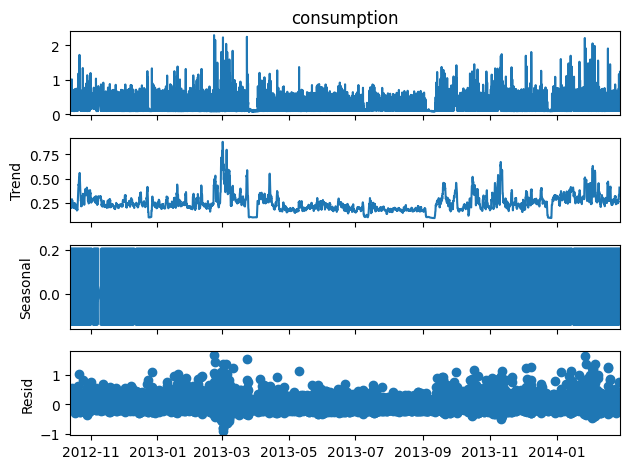

In [32]:
result = seasonal_decompose(hourly_data['consumption'].dropna(), model='additive', period=24)
result.plot()
plt.show()

### Daily

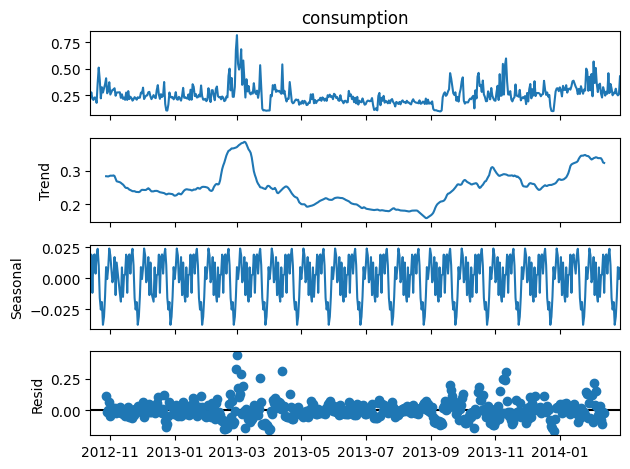

In [33]:
result = seasonal_decompose(daily_data['consumption'].dropna(), model='additive', period=30)
result.plot()
plt.show()

## First Difference

### Hourly Data

In [34]:
hourly_data['consumption_first_diff'] = hourly_data['consumption'].diff()

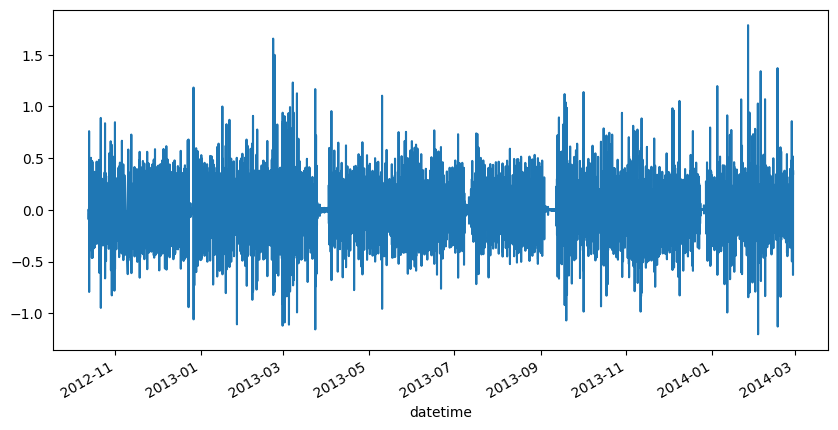

In [35]:
hourly_data['consumption_first_diff'].plot(figsize=(10, 5))
plt.show()

### Daily Data

In [36]:
daily_data['consumption_first_diff'] = daily_data['consumption'].diff()

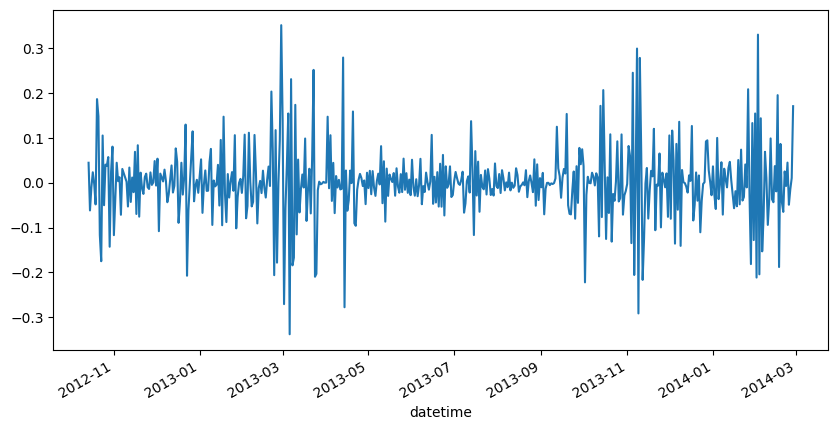

In [37]:
daily_data['consumption_first_diff'].plot(figsize=(10, 5))
plt.show()

# Test stationarity for different time aggregations

In [38]:
def test_stationarity(timeseries, title):

    plt.figure(figsize=(12, 6))
    plt.plot(timeseries, label='Original')

    rolling_mean = timeseries.rolling(window=10).mean()
    rolling_std = timeseries.rolling(window=10).std()

    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label='Rolling Std')

    plt.title(f'Rolling Statistics for {title} Data')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    adf_result = adfuller(timeseries.dropna())

    print('ADF Test Results:')
    print(f'ADF Statistic: {adf_result[0]:.4f}')
    print(f'p-value: {adf_result[1]:.4f}')
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print(f'\t{key}: {value:.4f}')

    if adf_result[1] <= 0.05:
        print("Conclusion: Time series is STATIONARY (ADF Test)")
    else:
        print("Conclusion: Time series is NON-STATIONARY (ADF Test)")

    kpss_result = kpss(timeseries.dropna())

    print('\nKPSS Test Results:')
    print(f'KPSS Statistic: {kpss_result[0]:.4f}')
    print(f'p-value: {kpss_result[1]:.4f}')
    print('Critical Values:')
    for key, value in kpss_result[3].items():
        print(f'\t{key}: {value:.4f}')

    if kpss_result[1] <= 0.05:
        print("Conclusion: Time series is NON-STATIONARY (KPSS Test)")
    else:
        print("Conclusion: Time series is STATIONARY (KPSS Test)")

    lags = min(40, len(timeseries) // 2 -1)

    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    plot_acf(timeseries.dropna(), ax=axes[0], lags=lags)
    plot_pacf(timeseries.dropna(), ax=axes[1], lags=lags)
    plt.suptitle(f'ACF and PACF for {title} Data')
    plt.tight_layout()
    plt.show()

## For Hourly data

Looking at these charts, I can see this hourly data shows strong patterns. The data clearly has a daily cycle, with peaks appearing every 24 hours on the left chart. The first few hours have the strongest relationship, with each hour heavily influenced by what happened just before it.
The right chart (PACF) confirms this by showing that once you account for the immediate hour-to-hour relationship, most of the apparent patterns disappear, except for the daily cycle that pops up again around the 24-hour mark.
This is typical for hourly measurements where activities follow a daily rhythm

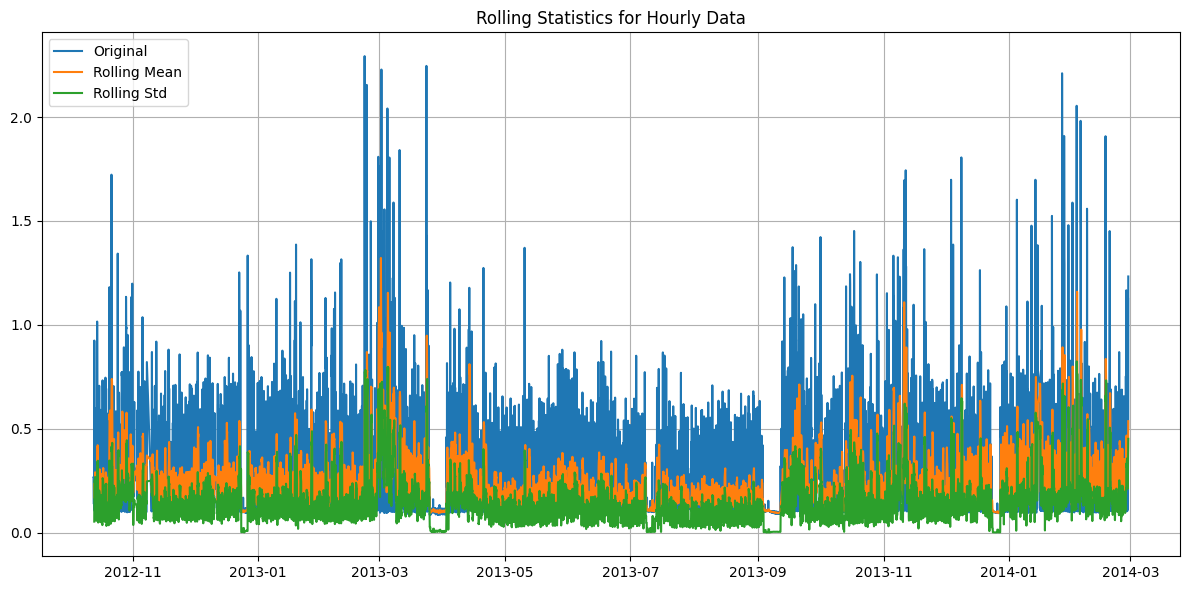

ADF Test Results:
ADF Statistic: -11.2416
p-value: 0.0000
Critical Values:
	1%: -3.4309
	5%: -2.8618
	10%: -2.5669
Conclusion: Time series is STATIONARY (ADF Test)

KPSS Test Results:
KPSS Statistic: 1.4260
p-value: 0.0100
Critical Values:
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390
Conclusion: Time series is NON-STATIONARY (KPSS Test)


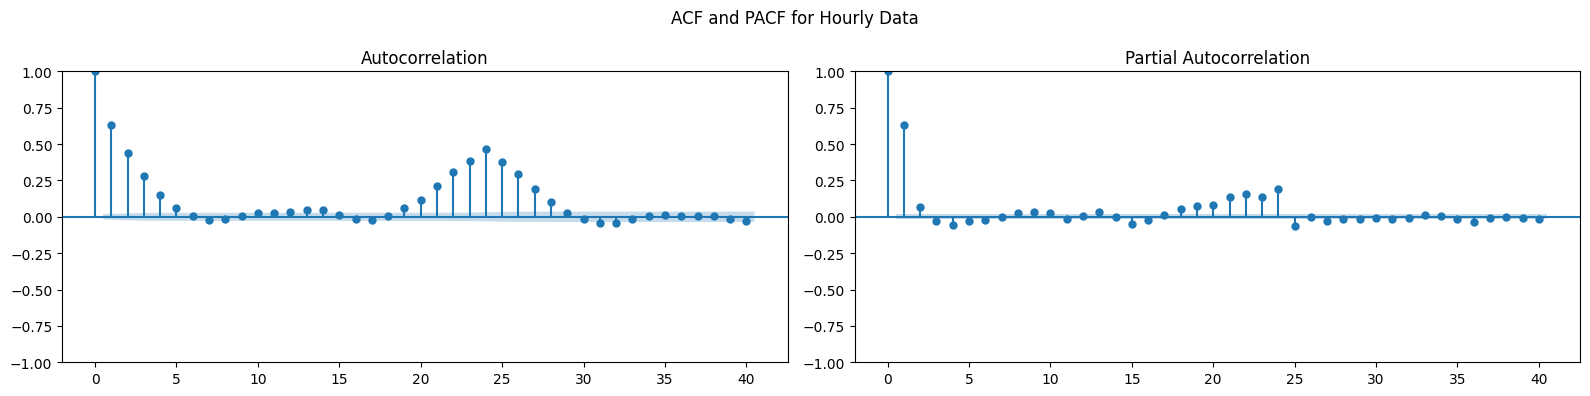

In [39]:
test_stationarity(hourly_data['consumption'], "Hourly")

## Daily data

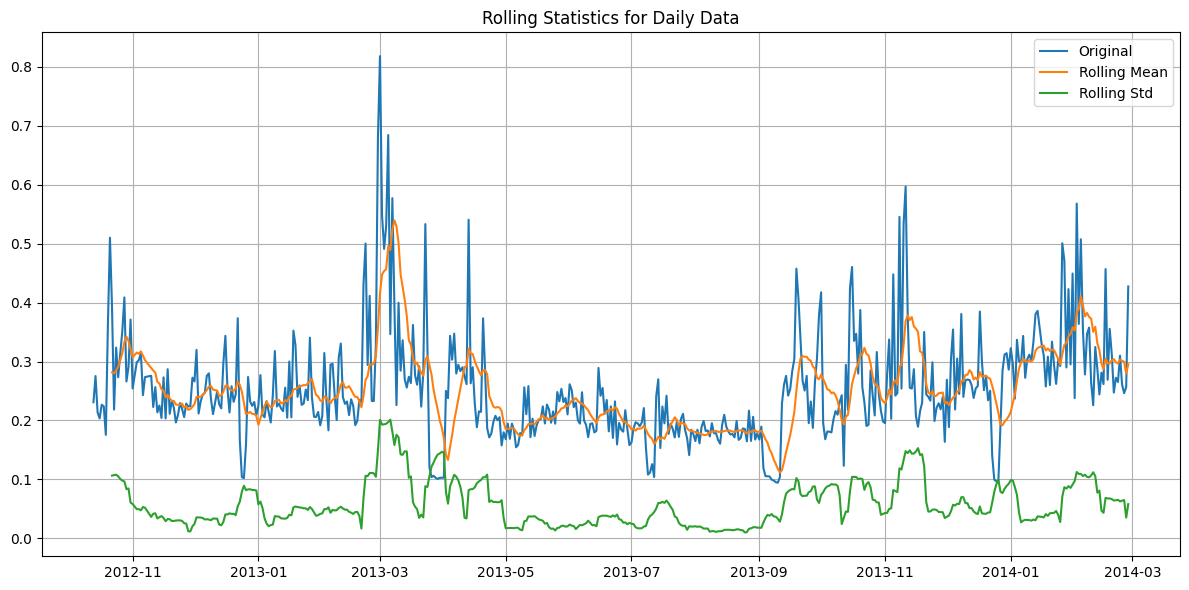

ADF Test Results:
ADF Statistic: -4.9233
p-value: 0.0000
Critical Values:
	1%: -3.4438
	5%: -2.8675
	10%: -2.5699
Conclusion: Time series is STATIONARY (ADF Test)

KPSS Test Results:
KPSS Statistic: 0.3574
p-value: 0.0955
Critical Values:
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390
Conclusion: Time series is STATIONARY (KPSS Test)


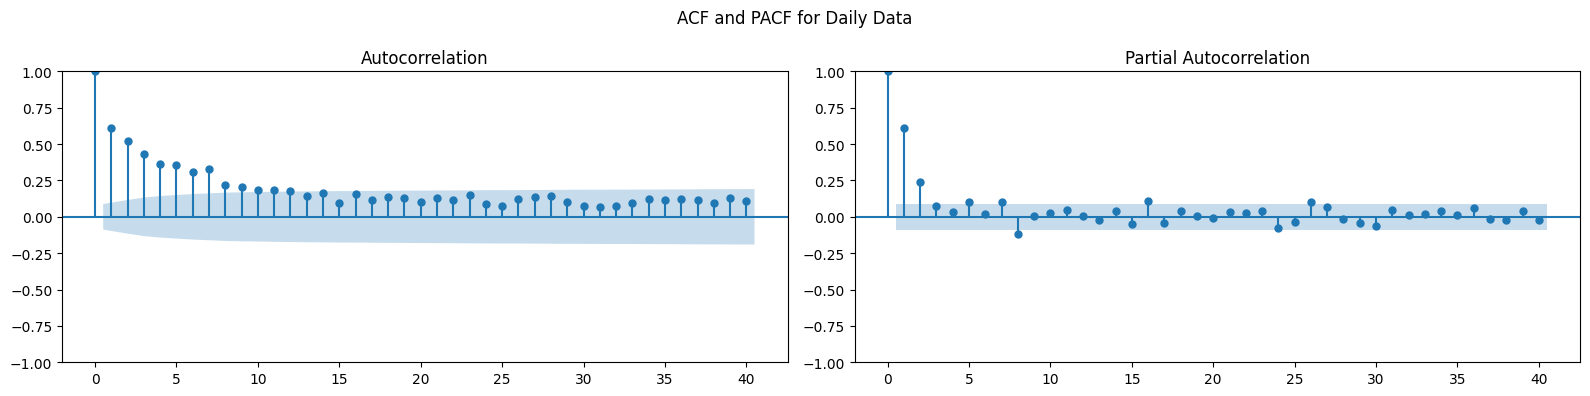

In [40]:
test_stationarity(daily_data['consumption'], "Daily")

## Daily data first difference

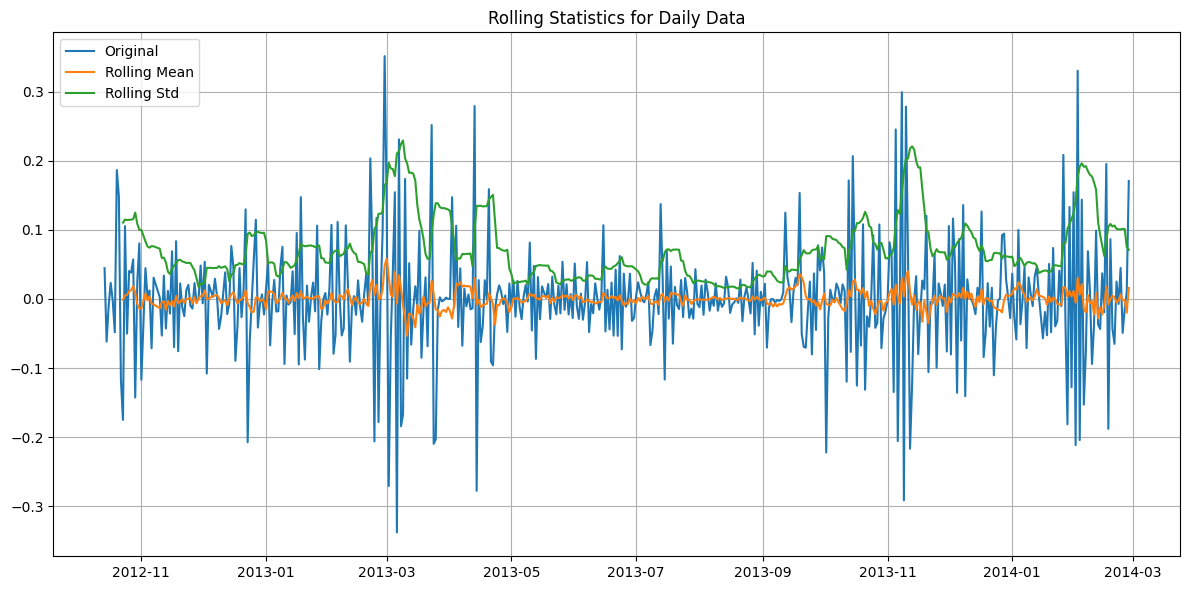

ADF Test Results:
ADF Statistic: -8.5465
p-value: 0.0000
Critical Values:
	1%: -3.4440
	5%: -2.8676
	10%: -2.5700
Conclusion: Time series is STATIONARY (ADF Test)

KPSS Test Results:
KPSS Statistic: 0.0632
p-value: 0.1000
Critical Values:
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390
Conclusion: Time series is STATIONARY (KPSS Test)


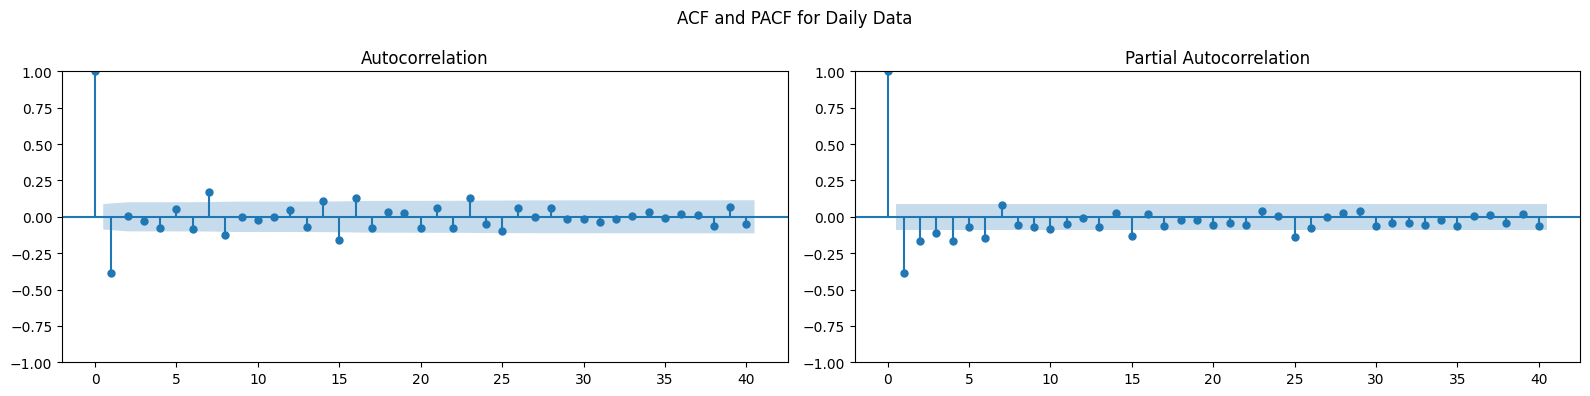

In [41]:
test_stationarity(daily_data['consumption_first_diff'], "Daily")

# Profit model

In [64]:
prophet_data = daily_data.reset_index()[['datetime', 'consumption']]
prophet_data.columns = ['ds', 'y']

In [68]:
model = Prophet()
model.fit(prophet_data)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/3fx06jr2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/g5jfvy7q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55424', 'data', 'file=/tmp/tmp1tpgd24d/3fx06jr2.json', 'init=/tmp/tmp1tpgd24d/g5jfvy7q.json', 'output', 'file=/tmp/tmp1tpgd24d/prophet_modelqzwpveku/prophet_model-20250422152055.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:20:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:20:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


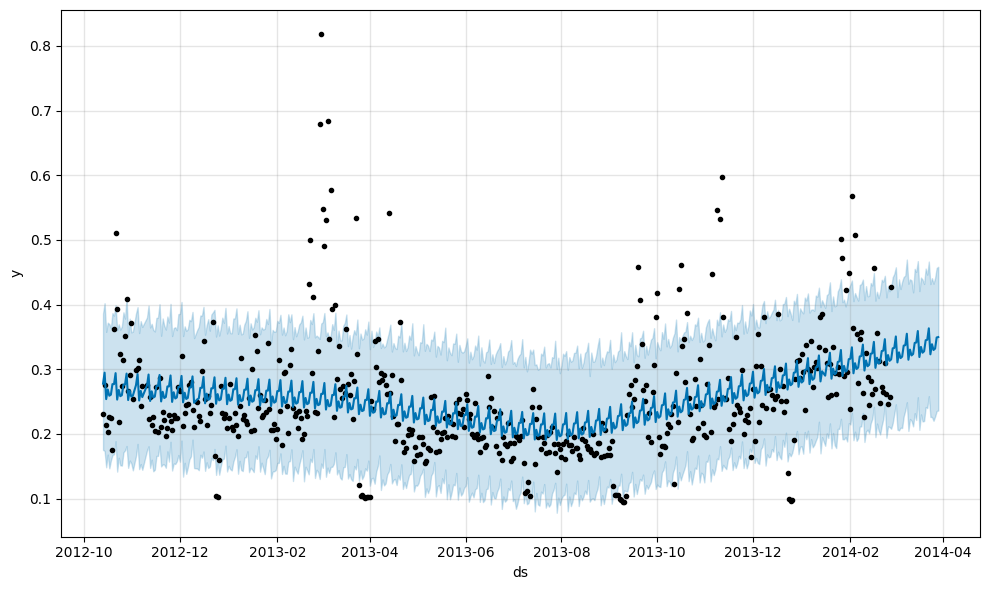

In [69]:
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)
fig = model.plot(forecast)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/mwlhix3g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/m43dosjj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50041', 'data', 'file=/tmp/tmp1tpgd24d/mwlhix3g.json', 'init=/tmp/tmp1tpgd24d/m43dosjj.json', 'output', 'file=/tmp/tmp1tpgd24d/prophet_modeloota9fkn/prophet_model-20250422152102.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:21:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:21:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


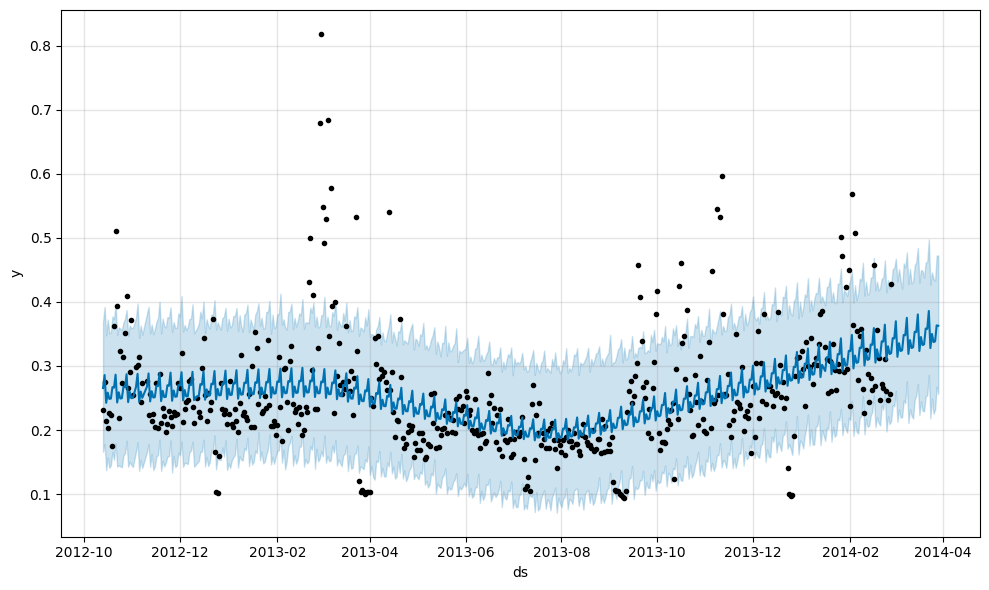

In [70]:
model = Prophet(
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.1,
    seasonality_prior_scale=10
)
model.fit(prophet_data)

future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

fig = model.plot(forecast)

In [71]:
forecast_filtered = forecast.set_index('ds').loc[prophet_data['ds']]
mae = mean_absolute_error(prophet_data['y'], forecast_filtered['yhat'])
print(f"MAE: {mae:.4f}")

MAE: 0.0546


## Grid Search

In [ ]:
train = prophet_data[:-30]
test = prophet_data[-30:]

In [ ]:
seasonality_modes = ['additive', 'multiplicative']
changepoint_scales = [0.001, 0.01, 0.1, 0.5]
seasonality_scales = [1, 5, 10, 15]
best_score = float('inf')
best_params = None

In [72]:
for mode, changepoint, seasonality in product(seasonality_modes, changepoint_scales, seasonality_scales):
    model = Prophet(
        seasonality_mode=mode,
        changepoint_prior_scale=changepoint,
        seasonality_prior_scale=seasonality
    )

    model.fit(train)
    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)

    forecast_tail = forecast.set_index('ds').loc[test['ds']]
    mae = mean_absolute_error(test['y'], forecast_tail['yhat'])

    print(f"Mode={mode}, Changepoint={changepoint}, Seasonality={seasonality} => MAE={mae:.4f}")

    if mae < best_score:
        best_score = mae
        best_params = (mode, changepoint, seasonality)

print(f"\n Best params: Mode={best_params[0]}, Changepoint={best_params[1]}, Seasonality={best_params[2]} with MAE={best_score:.4f}")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/oqy67ybq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/suy5_own.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88861', 'data', 'file=/tmp/tmp1tpgd24d/oqy67ybq.json', 'init=/tmp/tmp1tpgd24d/suy5_own.json', 'output', 'file=/tmp/tmp1tpgd24d/prophet_modelisdbicmv/prophet_model-20250422152202.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:22:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:22:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

Mode=additive, Changepoint=0.001, Seasonality=1 => MAE=0.0700


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/mcrbdih1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94594', 'data', 'file=/tmp/tmp1tpgd24d/nnj0e_kk.json', 'init=/tmp/tmp1tpgd24d/mcrbdih1.json', 'output', 'file=/tmp/tmp1tpgd24d/prophet_modelybdq1j5n/prophet_model-20250422152203.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:22:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:22:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/41176g4e.json


Mode=additive, Changepoint=0.001, Seasonality=5 => MAE=0.0700


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/6vscf5u4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87814', 'data', 'file=/tmp/tmp1tpgd24d/41176g4e.json', 'init=/tmp/tmp1tpgd24d/6vscf5u4.json', 'output', 'file=/tmp/tmp1tpgd24d/prophet_modelemdf6svs/prophet_model-20250422152204.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:22:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:22:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/r8zl1d99.json


Mode=additive, Changepoint=0.001, Seasonality=10 => MAE=0.0700


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/g2fzq8x9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75468', 'data', 'file=/tmp/tmp1tpgd24d/r8zl1d99.json', 'init=/tmp/tmp1tpgd24d/g2fzq8x9.json', 'output', 'file=/tmp/tmp1tpgd24d/prophet_modelmiaj5t9q/prophet_model-20250422152205.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:22:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:22:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mode=additive, Changepoint=0.001, Seasonality=15 => MAE=0.0700


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/sy5j9zxb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/522it1ea.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13849', 'data', 'file=/tmp/tmp1tpgd24d/sy5j9zxb.json', 'init=/tmp/tmp1tpgd24d/522it1ea.json', 'output', 'file=/tmp/tmp1tpgd24d/prophet_model6h33hre5/prophet_model-20250422152206.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:22:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:22:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

Mode=additive, Changepoint=0.01, Seasonality=1 => MAE=0.0791


15:22:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:22:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/309ta1l5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/lw_wr26b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17087', 'data', 'file=/tmp/tmp1tpgd24d/309ta1l5.json', 'init=/tmp/tmp1tpgd24d/lw_wr26b.json', 'output', 'file=/tmp/tmp1tpgd24d/prophet_modelio6bf2ev/prophet_model-20250422152208.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:22:08 - cmdstanpy - INFO - Chain [1] 

Mode=additive, Changepoint=0.01, Seasonality=5 => MAE=0.0785


15:22:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/03d_g_9o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/_ovpin27.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


Mode=additive, Changepoint=0.01, Seasonality=10 => MAE=0.0791


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19055', 'data', 'file=/tmp/tmp1tpgd24d/03d_g_9o.json', 'init=/tmp/tmp1tpgd24d/_ovpin27.json', 'output', 'file=/tmp/tmp1tpgd24d/prophet_modelhnb6nfyr/prophet_model-20250422152209.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:22:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:22:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/3f9p26tg.json


Mode=additive, Changepoint=0.01, Seasonality=15 => MAE=0.0788


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/o_gsiiea.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42889', 'data', 'file=/tmp/tmp1tpgd24d/3f9p26tg.json', 'init=/tmp/tmp1tpgd24d/o_gsiiea.json', 'output', 'file=/tmp/tmp1tpgd24d/prophet_modelky2ue94z/prophet_model-20250422152210.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:22:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:22:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/66p1nxg6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

Mode=additive, Changepoint=0.1, Seasonality=1 => MAE=0.0696


15:22:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/4xr_gioh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/_l_xi1l3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30324', 'data', 'file=/tmp/tmp1tpgd24d/4xr_gioh.json', 'init=/tmp/tmp1tpgd24d/_l_xi1l3.json', 'output', 'file=/tmp/tmp1tpgd24d/prophet_model9_bg2xfi/prophet_model-20250422152211.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:22:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mode=additive, Changepoint=0.1, Seasonality=5 => MAE=0.0700


15:22:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/7t39wd78.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/tzu1c0le.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79569', 'data', 'file=/tmp/tmp1tpgd24d/7t39wd78.json', 'init=/tmp/tmp1tpgd24d/tzu1c0le.json', 'output', 'file=/tmp/tmp1tpgd24d/prophet_model6i31laxk/prophet_model-20250422152212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:22:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mode=additive, Changepoint=0.1, Seasonality=10 => MAE=0.0698


15:22:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/wpuhnf_j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/ltd8_xhh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93208', 'data', 'file=/tmp/tmp1tpgd24d/wpuhnf_j.json', 'init=/tmp/tmp1tpgd24d/ltd8_xhh.json', 'output', 'file=/tmp/tmp1tpgd24d/prophet_modelinnz7rvo/prophet_model-20250422152213.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:22:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mode=additive, Changepoint=0.1, Seasonality=15 => MAE=0.0701


15:22:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/scxctkdy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/_w_qah3z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22228', 'data', 'file=/tmp/tmp1tpgd24d/scxctkdy.json', 'init=/tmp/tmp1tpgd24d/_w_qah3z.json', 'output', 'file=/tmp/tmp1tpgd24d/prophet_modelrmn01ixb/prophet_model-20250422152214.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:22:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mode=additive, Changepoint=0.5, Seasonality=1 => MAE=0.0664


15:22:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/9y11leq3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/c162tj9y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91346', 'data', 'file=/tmp/tmp1tpgd24d/9y11leq3.json', 'init=/tmp/tmp1tpgd24d/c162tj9y.json', 'output', 'file=/tmp/tmp1tpgd24d/prophet_modelf4mbfdu4/prophet_model-20250422152215.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:22:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mode=additive, Changepoint=0.5, Seasonality=5 => MAE=0.0664


15:22:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/_wxpmh_f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/lk2fu_ox.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87759', 'data', 'file=/tmp/tmp1tpgd24d/_wxpmh_f.json', 'init=/tmp/tmp1tpgd24d/lk2fu_ox.json', 'output', 'file=/tmp/tmp1tpgd24d/prophet_modelkuyrf1b1/prophet_model-20250422152216.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:22:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mode=additive, Changepoint=0.5, Seasonality=10 => MAE=0.0663


15:22:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/uzk54ej0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/3vtdfmjz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16051', 'data', 'file=/tmp/tmp1tpgd24d/uzk54ej0.json', 'init=/tmp/tmp1tpgd24d/3vtdfmjz.json', 'output', 'file=/tmp/tmp1tpgd24d/prophet_modelncw6rh4a/prophet_model-20250422152216.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:22:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:22:16 - cmdstanpy - INFO - Chain [1] 

Mode=additive, Changepoint=0.5, Seasonality=15 => MAE=0.0664


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/vcejchbp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/18w_pgr2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61524', 'data', 'file=/tmp/tmp1tpgd24d/vcejchbp.json', 'init=/tmp/tmp1tpgd24d/18w_pgr2.json', 'output', 'file=/tmp/tmp1tpgd24d/prophet_model964oniqx/prophet_model-20250422152217.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:22:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mode=multiplicative, Changepoint=0.001, Seasonality=1 => MAE=0.0690


15:22:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/tog17agw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/7f5s_elc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43984', 'data', 'file=/tmp/tmp1tpgd24d/tog17agw.json', 'init=/tmp/tmp1tpgd24d/7f5s_elc.json', 'output', 'file=/tmp/tmp1tpgd24d/prophet_model5shvarkq/prophet_model-20250422152218.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:22:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mode=multiplicative, Changepoint=0.001, Seasonality=5 => MAE=0.0690


15:22:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/urithskh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/yu2efoiq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51808', 'data', 'file=/tmp/tmp1tpgd24d/urithskh.json', 'init=/tmp/tmp1tpgd24d/yu2efoiq.json', 'output', 'file=/tmp/tmp1tpgd24d/prophet_modelx9d43fyp/prophet_model-20250422152218.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:22:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mode=multiplicative, Changepoint=0.001, Seasonality=10 => MAE=0.0690


15:22:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/8ovi3z72.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/nn70is1b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23848', 'data', 'file=/tmp/tmp1tpgd24d/8ovi3z72.json', 'init=/tmp/tmp1tpgd24d/nn70is1b.json', 'output', 'file=/tmp/tmp1tpgd24d/prophet_modelf3jjnh2g/prophet_model-20250422152219.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:22:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mode=multiplicative, Changepoint=0.001, Seasonality=15 => MAE=0.0690


15:22:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/1fgg_aya.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/fbeala3p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19236', 'data', 'file=/tmp/tmp1tpgd24d/1fgg_aya.json', 'init=/tmp/tmp1tpgd24d/fbeala3p.json', 'output', 'file=/tmp/tmp1tpgd24d/prophet_modelhl7rhf8s/prophet_model-20250422152220.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:22:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mode=multiplicative, Changepoint=0.01, Seasonality=1 => MAE=0.0796


15:22:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/jsmdxvwm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/a2ffdn32.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65254', 'data', 'file=/tmp/tmp1tpgd24d/jsmdxvwm.json', 'init=/tmp/tmp1tpgd24d/a2ffdn32.json', 'output', 'file=/tmp/tmp1tpgd24d/prophet_model3a1m7bya/prophet_model-20250422152221.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:22:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:22:21 - cmdstanpy - INFO - Chain [1] 

Mode=multiplicative, Changepoint=0.01, Seasonality=5 => MAE=0.0798


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/wpt6fn0k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/59f74ctk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76203', 'data', 'file=/tmp/tmp1tpgd24d/wpt6fn0k.json', 'init=/tmp/tmp1tpgd24d/59f74ctk.json', 'output', 'file=/tmp/tmp1tpgd24d/prophet_modelz5ewzbfn/prophet_model-20250422152221.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:22:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mode=multiplicative, Changepoint=0.01, Seasonality=10 => MAE=0.0803


15:22:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/3a28j7hj.json


Mode=multiplicative, Changepoint=0.01, Seasonality=15 => MAE=0.0803


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/nanb2_id.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69280', 'data', 'file=/tmp/tmp1tpgd24d/3a28j7hj.json', 'init=/tmp/tmp1tpgd24d/nanb2_id.json', 'output', 'file=/tmp/tmp1tpgd24d/prophet_model_kh2g5a6/prophet_model-20250422152222.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:22:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:22:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/6d12p1no.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

Mode=multiplicative, Changepoint=0.1, Seasonality=1 => MAE=0.0696


15:22:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/xfvx30dr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/aoiyconl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99780', 'data', 'file=/tmp/tmp1tpgd24d/xfvx30dr.json', 'init=/tmp/tmp1tpgd24d/aoiyconl.json', 'output', 'file=/tmp/tmp1tpgd24d/prophet_modellye20vkl/prophet_model-20250422152224.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:22:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mode=multiplicative, Changepoint=0.1, Seasonality=5 => MAE=0.0693


15:22:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/gmjf20s7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/18kky5jt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77825', 'data', 'file=/tmp/tmp1tpgd24d/gmjf20s7.json', 'init=/tmp/tmp1tpgd24d/18kky5jt.json', 'output', 'file=/tmp/tmp1tpgd24d/prophet_modelhag_nva4/prophet_model-20250422152225.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:22:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mode=multiplicative, Changepoint=0.1, Seasonality=10 => MAE=0.0695


15:22:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/ae9_lc3x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/lj296zap.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93115', 'data', 'file=/tmp/tmp1tpgd24d/ae9_lc3x.json', 'init=/tmp/tmp1tpgd24d/lj296zap.json', 'output', 'file=/tmp/tmp1tpgd24d/prophet_modelqjo6w57j/prophet_model-20250422152225.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:22:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mode=multiplicative, Changepoint=0.1, Seasonality=15 => MAE=0.0691


15:22:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/mdexwozb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/ttf0k8cg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68599', 'data', 'file=/tmp/tmp1tpgd24d/mdexwozb.json', 'init=/tmp/tmp1tpgd24d/ttf0k8cg.json', 'output', 'file=/tmp/tmp1tpgd24d/prophet_modeliil_sb8i/prophet_model-20250422152226.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:22:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mode=multiplicative, Changepoint=0.5, Seasonality=1 => MAE=0.0662


15:22:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/0l1zdl07.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/xv3pj86c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45535', 'data', 'file=/tmp/tmp1tpgd24d/0l1zdl07.json', 'init=/tmp/tmp1tpgd24d/xv3pj86c.json', 'output', 'file=/tmp/tmp1tpgd24d/prophet_model0mlmio9v/prophet_model-20250422152227.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:22:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:22:27 - cmdstanpy - INFO - Chain [1] 

Mode=multiplicative, Changepoint=0.5, Seasonality=5 => MAE=0.0662


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/5wh3l_xc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/ifboxn_5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9970', 'data', 'file=/tmp/tmp1tpgd24d/5wh3l_xc.json', 'init=/tmp/tmp1tpgd24d/ifboxn_5.json', 'output', 'file=/tmp/tmp1tpgd24d/prophet_modelfxj0zr3a/prophet_model-20250422152227.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:22:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mode=multiplicative, Changepoint=0.5, Seasonality=10 => MAE=0.0662


15:22:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mode=multiplicative, Changepoint=0.5, Seasonality=15 => MAE=0.0663

✅ Best params: Mode=multiplicative, Changepoint=0.5, Seasonality=1 with MAE=0.0662


 The forecast appears to model the general trend and seasonality, though considerable unexplained variation remains in the observations.

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/nft5gr1y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1tpgd24d/5klest5y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41018', 'data', 'file=/tmp/tmp1tpgd24d/nft5gr1y.json', 'init=/tmp/tmp1tpgd24d/5klest5y.json', 'output', 'file=/tmp/tmp1tpgd24d/prophet_modelqh6x53tp/prophet_model-20250422152641.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:26:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:26:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


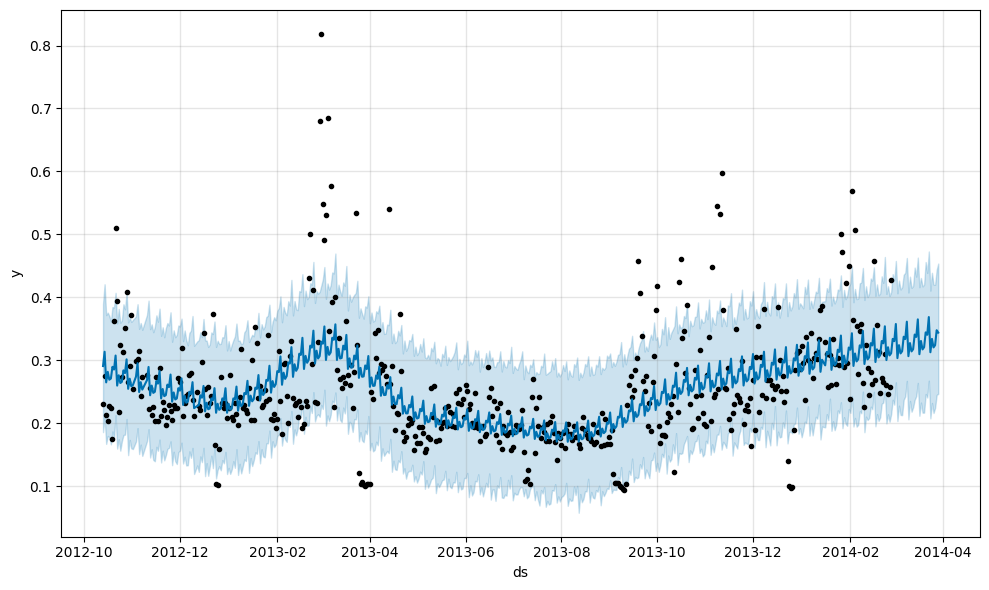

In [75]:
model = Prophet(seasonality_mode='multiplicative', changepoint_prior_scale=0.5, seasonality_prior_scale=1)
model.fit(prophet_data)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)
fig = model.plot(forecast)